# Exploring sea ice heights with ICESat-2 (ATL07)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl07.   

* Notebook author: Ellen Buckley, heavily based on 2019 Hackweek notebook by Alek Petty, and  relying extensively on above product manuals.    
* Description: Notebook describing the ICESat-2 ATL07 product.   
* Input requirements: Demo ATL07 data file   
* Date: June 2020
* More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_rel003.pdf    and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL07-ATL10_Known_Issues_v002%2811-25-2019%29.pdf


## Notebook objectives
* General understanding of the data included in a typical ATL07 file.
* Reading in, plotting and basic analysis of ATL07 data.
* How is ATL07 data used to generate ATL10 sea ice freeboards and what to look out for when using either product.


In [4]:
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
import s3fs
import scipy
#from astropy.time import Time
from icepyx import icesat2data as ipd

## Select and Import Data

#### Granule Selection

So that we can compare the ATL07 data with the ATL03 data in this notebook, we will pull the same RGT for ATL07.

Naming convention for ATL07 files: Instead of 14 regions, there are only 2: Northern Hemisphere (01), and Southern Hemisphere (02). For Northern Hemisphere products look for files that start with 'ATL07-01'

In this example we will be using: 'ATL07-01_20190206121103_06120201_002_01.h5'

#### Import Data

You can either grab this file from Amazon S3 (at the hackweek) or download from NSIDC if you are running this on your local machine

In [8]:
data_loc='../Data/'
fname='ATL07-01_20190430080720_04900301_002_01.h5'

In [9]:
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
s3File='pangeo-data-upload-oregon/icesat2/sea-ice-data/'+fname
localFilePath=data_loc+fname
fs.get(s3File, localFilePath);

In [10]:
f = h5py.File(data_loc+fname, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f['orbit_info/sc_orient'][0])

0


We know we are in backward orientation because we are using same rgt from same day as  the ATL03 example but it just as easy to check. Here are the ATL07 parameters we are interested in using in this notebook:

In Group: gtx/sea_ice_segments/
* latitude
* longitude
* delta_time
* seg_dist_x

In Group: gtx/sea_ice_segments/heights/
* height_segment_height
* height_segment_confidence
* height_segment_type
* height_segment_ssh_flag
* height_segment_w_gaussian

In Group: gtx/sea_ice_segments/stats/
* photon_rate
* cloud_flag_asr

In Group: gtx/sea_ice_segments/geophysical/
* height_segment_mss

In [15]:
epoch=f['ancillary_data/atlas_sdp_gps_epoch'][:]
def getATL07(f,beam):
    lats = f[beam+'/sea_ice_segments/latitude'][:]
    lons = f[beam+'/sea_ice_segments/longitude'][:]
    dt = f[beam+'/sea_ice_segments/delta_time'][:]
    seg_x = f[beam+'/sea_ice_segments/seg_dist_x'][:]
    heights = f[beam+'/sea_ice_segments/heights/height_segment_height'][:]
    conf = f[beam+'/sea_ice_segments/heights/height_segment_confidence'][:]
    stype = f[beam+'/sea_ice_segments/heights/height_segment_type'][:]
    ssh_flag = f[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:]
    gauss = f[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:]
    photon_rate = f[beam+'/sea_ice_segments/stats/photon_rate'][:]
    cloud = f[beam+'/sea_ice_segments/stats/cloud_flag_asr'][:]
    mss= f[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]
    df07=pd.DataFrame({'lats':lats,'lons':lons,'heights':heights,'dt':dt,'conf':conf,'stype':stype,'ssh_flag':ssh_flag,'gauss':gauss,'photon_rate':photon_rate,'cloud':cloud, 'mss':mss})

    return df07

In [13]:
beam='gt1l'
df07=getATL07(f,beam)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss
0,64.630882,-38.745903,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.422905
1,64.632848,-38.746144,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.417488
2,64.657136,-38.749144,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.357327
3,64.687398,-38.752883,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.284157
4,64.687398,-38.752883,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.284157


## Map data


#### Cloud flag

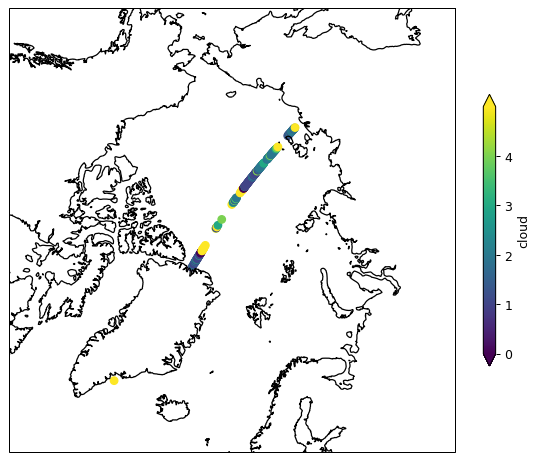

In [18]:
var= 'cloud' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=5
ticks=np.arange(vmin,vmax,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df07['lons'][::1000], df07['lats'][::1000],c=df07[var][::1000], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())#plt.cm.get_cmap('RdYlGn').reversed()
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

## Impact of Clouds on Data

Here we investigate a section of data that transitions from clear to cloudy and see how that impacts the parameters

#### How do clouds affect parameters?

In [19]:
# cut to region that has clear and cloudy data APRIL2
minlat=85.6
maxlat=86
minlon=-30
region=(df07.lats>minlat)&(df07.lats<maxlat)&(df07.lons>minlon)
df07_cut=df07[region]

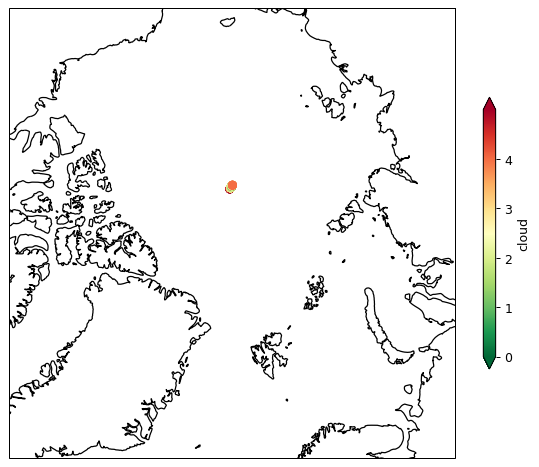

In [20]:
var= 'cloud' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=5
ticks=np.arange(vmin,vmax,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::10], df07_cut['lats'][::10],c=df07_cut[var][::10], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

Text(0, 0.5, 'photon rate')

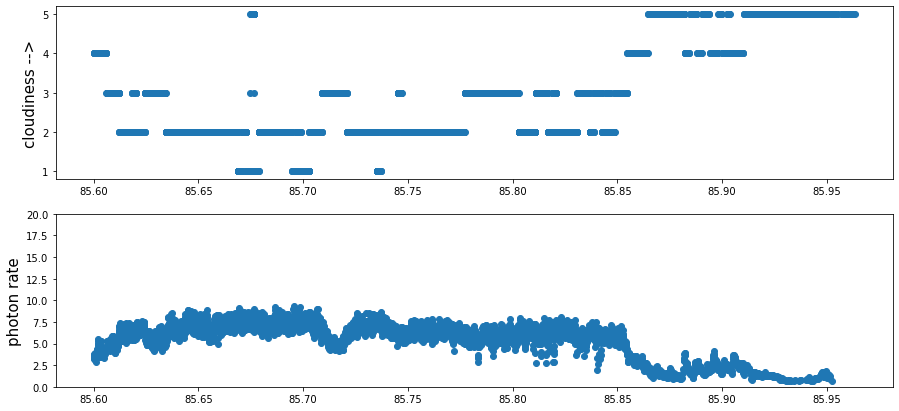

In [21]:
fig,ax=plt.subplots(2,1,figsize=(15,7))
ax[0].scatter(df07_cut.lats,df07_cut.cloud)
ax[0].set_ylabel('cloudiness -->',fontsize=15)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('photon rate',fontsize=15)

#### Lets look at how clouds affect the ATL03 data

In [24]:
fname='ATL03_20190430082817_04900304_003_01.h5'

In [23]:
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
s3File='pangeo-data-upload-oregon/icesat2/sea-ice-data/'+fname
localFilePath=data_loc+fname
fs.get(s3File, localFilePath);

In [25]:
f = h5py.File(data_loc+fname, 'r')
beam='gt1l'
def getATL03(f,beam):
    heights=f[beam+'/heights/h_ph'][:]
    lats=f[beam+'/heights/lat_ph'][:]
    lons=f[beam+'/heights/lon_ph'][:]
    dt=f[beam+'/heights/delta_time'][:]# time is in seconds 
    epoch=f['/ancillary_data/atlas_sdp_gps_epoch'][0]
    conf=f[beam+'/heights/signal_conf_ph'][:,2] #choose column 2 for confidence of sea ice photons

    df03=pd.DataFrame({'lats':lats,'lons':lons,'heights':heights,'dt':dt,'conf':conf})
    return df03
df03=getATL03(f,beam)
df03.head()


,lats,lons,heights,dt,conf
0,80.057553,-44.951288,1626.557007,4.184809e+07,-1
1,80.057542,-44.951344,1645.018433,4.184809e+07,-1
2,80.057577,-44.951254,1609.915405,4.184809e+07,-1
3,80.057584,-44.951258,1608.427856,4.184809e+07,-1
4,80.057574,-44.951349,1635.609009,4.184809e+07,-1


In [26]:
# cut df03 to region of interest
region=(df03.lats>minlat)&(df03.lats<maxlat)&(df03.lons>minlon)
df03_cut=df03[region]

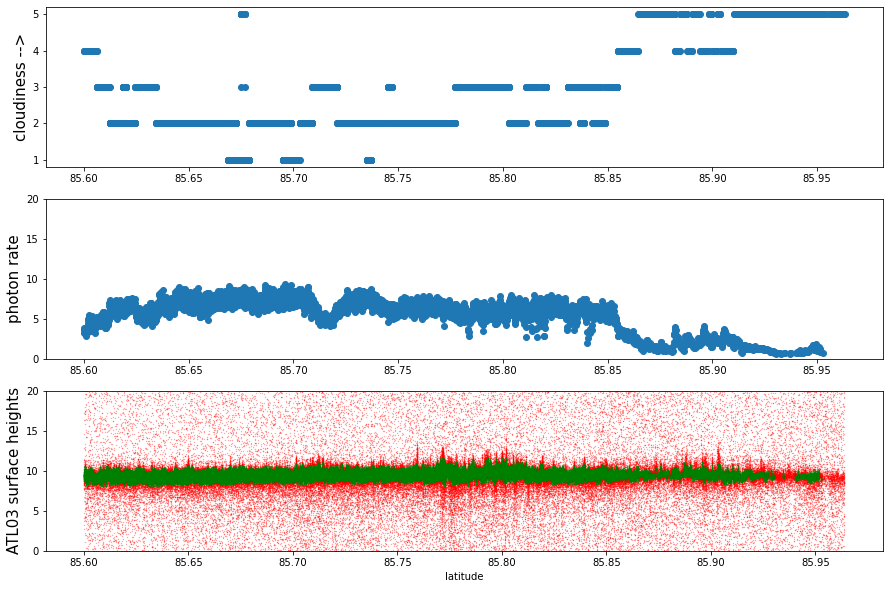

In [27]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].scatter(df07_cut.lats,df07_cut.cloud)
ax[0].set_ylabel('ATL07 cloudiness -->',fontsize=15)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('ATL07 photon rate',fontsize=15)
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3],c='r',s=.1,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2],c='g',s=.1,alpha=.5)
ax[2].set_ylim(0,20)
ax[2].set_ylabel('ATL03 surface heights',fontsize=15)
ax[2].set_xlabel('latitude');

In [28]:
# zoom in on transition
# cut to region that has clear and cloudy data
minlat=85.84
maxlat=85.9
minlon=-30
region=(df07.lats>minlat)&(df07.lats<maxlat)&(df07.lons>minlon)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>minlat)&(df03.lats<maxlat)&(df03.lons>minlon)
df03_cut=df03[region]

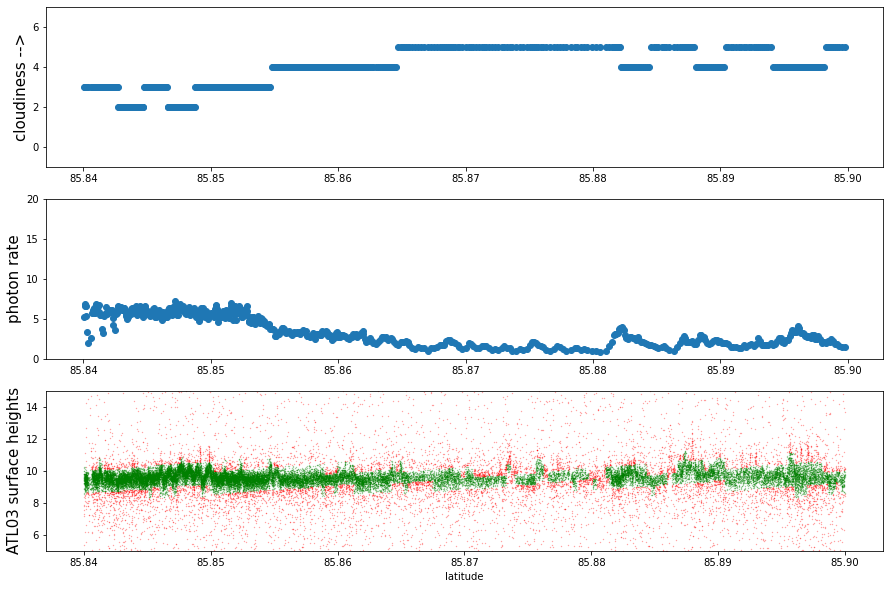

In [29]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].scatter(df07_cut.lats,df07_cut.cloud)
ax[0].set_ylabel('ATL07 cloudiness -->',fontsize=15)
ax[0].set_ylim(-1,7)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('ATL07 photon rate',fontsize=15)
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3],c='r',s=.1,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2],c='g',s=.1,alpha=.5)
ax[2].set_ylim(5,15)
ax[2].set_ylabel('ATL03 surface heights',fontsize=15)
ax[2].set_xlabel('latitude');

## Surface type classification

Not we want to look at the surface type classifications in ATL07 and think about how these are used to generate ATL10

Surface type paramter: Value that indicates segment surface type as sea ice or different types of sea surface. 

 0 cloud_covered 
 
 1 other 
 
 2 specular_lead_low_w_bkg 
 
 3 specular_lead_low 
 
 4 specular_lead_high_w_bkg 
 
 5 specular_lead_high 
 
 6 dark_lead_smooth_w_bkg 
 
 7 dark_lead_smooth 
 
 8 dark_lead_rough_w_bkg 
 
 9 dark_lead_rough

In [30]:
fname='ATL07-01_20190324002217_13070201_002_01.h5'

In [31]:
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
s3File='pangeo-data-upload-oregon/icesat2/sea-ice-data/'+fname
localFilePath=data_loc+fname
fs.get(s3File, localFilePath);

In [32]:
f = h5py.File(data_loc+fname, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f['orbit_info/sc_orient'][0])

0


In [33]:
beam='gt1l'
df07= getATL07(f,beam)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss
0,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923
1,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923
2,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923
3,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923
4,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923


In [34]:
fname='ATL03_20190324004315_13070204_003_01.h5'

In [35]:
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
s3File='pangeo-data-upload-oregon/icesat2/sea-ice-data/'+fname
localFilePath=data_loc+fname
fs.get(s3File, localFilePath);

In [36]:
f = h5py.File(data_loc+fname, 'r')
beam='gt1l'
df03=getATL03(f, beam)
df03.head()

,lats,lons,heights,dt,conf
0,79.993240,96.245996,-1852.795776,3.862339e+07,-1
1,79.993250,96.246020,-1772.485352,3.862339e+07,-1
2,79.993249,96.246143,-1507.922729,3.862339e+07,-1
3,79.993259,96.246068,-1644.257935,3.862339e+07,-1
4,79.993263,96.245989,-1803.527100,3.862339e+07,-1


In [37]:
minlat=85.52
maxlat=85.57
maxlon=0
region=(df07.lats>minlat)&(df07.lats<maxlat)&(df07.lons<maxlon)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>minlat)&(df03.lats<maxlat)&(df03.lons<maxlon)
df03_cut=df03[region]


In [38]:
mss_corr=scipy.interpolate.interp1d(df07.dt.values,df07.mss.values)
df03_cut['mss']=mss_corr(df03_cut.dt.values)
df03_cut.head()


,lats,lons,heights,dt,conf,mss
4036701,85.569996,-46.016583,21.798777,3.862361e+07,1,19.821533
4036702,85.569996,-46.016582,20.282537,3.862361e+07,4,19.821533
4036703,85.569996,-46.016579,15.536215,3.862361e+07,1,19.821533
4036704,85.569996,-46.016582,20.189342,3.862361e+07,4,19.821533
4036705,85.569996,-46.016582,21.481829,3.862361e+07,1,19.821533


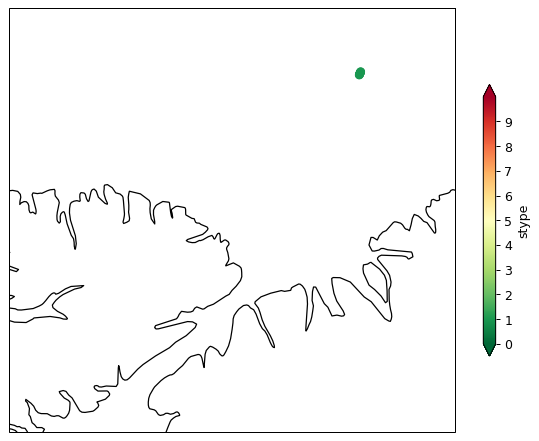

In [42]:
var= 'stype' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=10
ticks=np.arange(vmin,vmax,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-50)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-80,-40,80,86], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

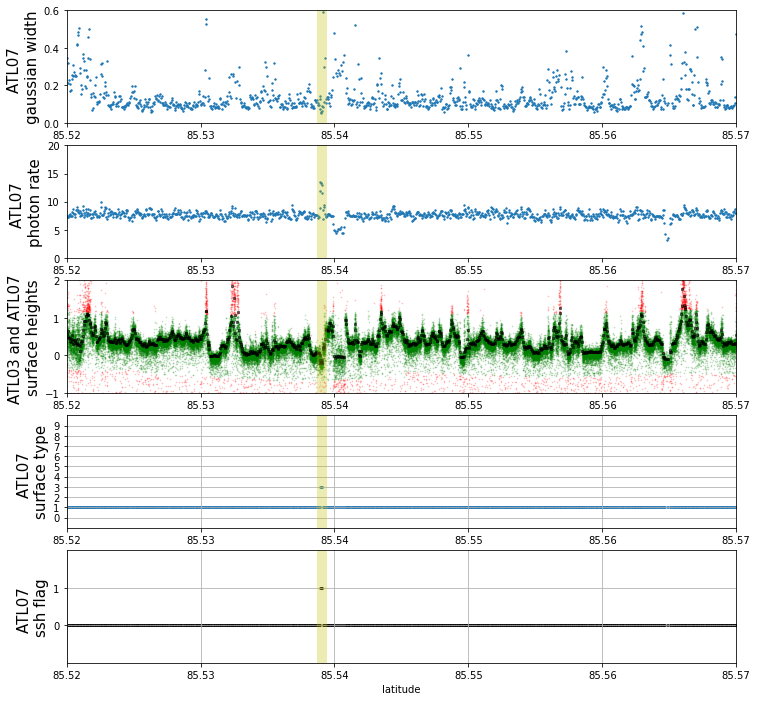

In [46]:
fig,ax=plt.subplots(5,1,figsize=(12,12))

ax[0].scatter(df07_cut.lats,df07_cut.gauss,s=2)
ax[0].set_ylabel('ATL07 \ngaussian width',fontsize=15)
ax[0].set_ylim(0,.6)


ax[1].scatter(df07_cut.lats,df07_cut.photon_rate,s=2)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('ATL07 \nphoton rate',fontsize=15)

ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3]-df03_cut.mss[df03_cut.conf<3],c='r',s=.5,alpha=.2)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2]-df03_cut.mss[df03_cut.conf>2],c='g',s=.5,alpha=.2)
ax[2].scatter(df07_cut.lats,df07_cut.heights,marker='s',s=2,c='k',alpha=.5)
ax[2].set_ylim(-1,2)
ax[2].set_ylabel('ATL03 and ATL07 \nsurface heights',fontsize=15)

ax[3].scatter(df07_cut.lats,df07_cut.stype,s=2)
ax[3].set_ylim(-1,10)
ax[3].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[3].grid()
ax[3].set_yticks(np.arange(0,10,1))

ax[4].scatter(df07_cut.lats,df07_cut.ssh_flag,c='k',s=2)
ax[4].grid()
ax[4].set_ylim(-1,2)
ax[4].set_yticks(np.arange(0,2,1))
ax[4].set_ylabel('ATL07 \nssh flag',fontsize=15)

ax[4].set_xlabel('latitude')

for a in np.arange(0,5):
    ax[a].set_xlim(minlat,maxlat)
    ax[a].axvline(df07_cut[df07_cut.ssh_flag==1].lats.values[0],c='y',alpha=.3, linewidth=10)

